# Dietox data: Growth curves of pigs in a 3x3 factorial experiment
#### For more detail: https://www.rdocumentation.org/packages/doBy/versions/4.6-3/topics/data-dietox

#### Here, the data has the mean weight of pigs as the target variable and it is a linear function of the time variable. The experiment was conducted on 72 pigs and has 861 data points.


In [5]:
import os
os.chdir("..")

In [7]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jenkspy import jenks_breaks
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder


from utils.Thesis_models import *
from utils import Thesis_viz as viz

In [3]:
def run_model(model, all_args):
    arg_names = model.__code__.co_varnames[:model.__code__.co_argcount]
    model_args = {k: all_args[k] for k in arg_names if k in all_args}
    return model(**model_args)

def get_reduced_data(label_df, column_break):
    
    zone_indices = {zone : list(label_df[label_df[column_break] == zone].index) \
                                                for zone in np.unique(label_df[column_break])}
    mapping_dict = {value: key for key, values in zone_indices.items() for value in values}
    data = df.copy()
    data['gE_new'] = df['gV'].map(mapping_dict)
    
    return data

def plot_mixed_effects(data, feature, group, target,legends = False):
    
    fig, ax = plt.subplots(figsize=(10, 7), dpi=100)

    col = str(group)

    for i in np.unique(data[col]):
        sns.regplot(x = data[data[col] == i][str(feature)], y = data[data[col] == i][str(target)],\
                    label = str(group)+":"+str(i),scatter_kws={"alpha": 1})
    
    if legends == True:
        plt.legend(loc='best')
    plt.ylabel(str(target), fontsize = 12)
    plt.xlabel(str(feature), fontsize = 12)

In [8]:
data  = pd.read_csv("datasets\dietox.csv", index_col=False)
data

,rownames,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time
0,1,4601,Evit000,Cu000,1,26.5,26.50000,NaN,1
1,2,4601,Evit000,Cu000,1,26.5,27.59999,5.200005,2
2,3,4601,Evit000,Cu000,1,26.5,36.50000,17.600000,3
3,4,4601,Evit000,Cu000,1,26.5,40.29999,28.500000,4
4,5,4601,Evit000,Cu000,1,26.5,49.09998,45.200001,5
...,...,...,...,...,...,...,...,...,...
856,857,8442,Evit000,Cu175,24,25.7,73.19995,83.800003,8
857,858,8442,Evit000,Cu175,24,25.7,81.69995,99.800003,9
858,859,8442,Evit000,Cu175,24,25.7,90.29999,115.200001,10
859,860,8442,Evit000,Cu175,24,25.7,96.00000,133.200001,11


In [10]:
df = data[['Pig', 'Time', 'Weight']]
df

,Pig,Time,Weight
0,4601,1,26.50000
1,4601,2,27.59999
2,4601,3,36.50000
3,4601,4,40.29999
4,4601,5,49.09998
...,...,...,...
856,8442,8,73.19995
857,8442,9,81.69995
858,8442,10,90.29999
859,8442,11,96.00000


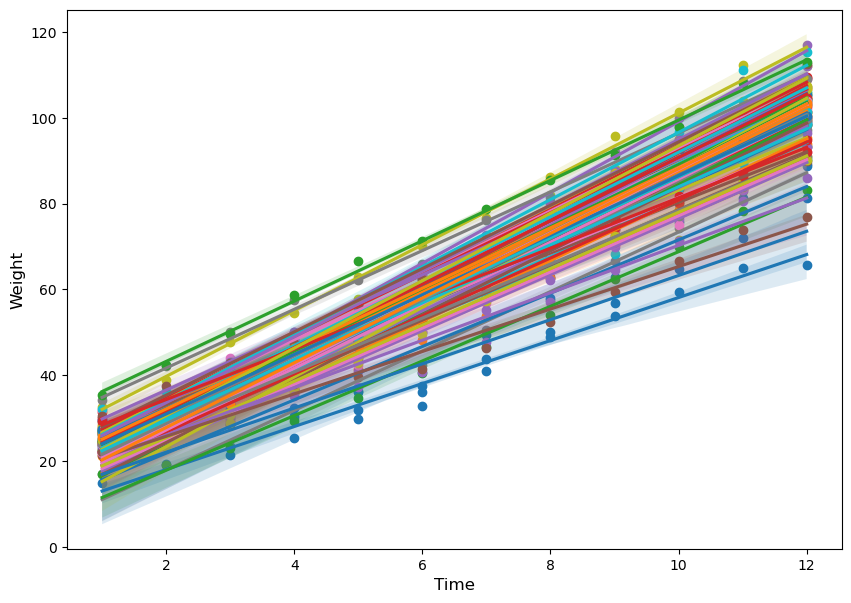

In [9]:
plot_mixed_effects(data, 'Time', 'Pig', 'Weight')

In [12]:
df = df.rename(columns={'Weight': 'y', 'Time':'f0', 'Pig':'gV'})
ordinal_encoder = OrdinalEncoder()
df['gV'] = ordinal_encoder.fit_transform(np.array(df['gV']).reshape(-1,1))
df['gV'] = df['gV'].astype(int)
df

,gV,f0,y
0,0,1,26.50000
1,0,2,27.59999
2,0,3,36.50000
3,0,4,40.29999
4,0,5,49.09998
...,...,...,...
856,71,8,73.19995
857,71,9,81.69995
858,71,10,90.29999
859,71,11,96.00000


### Initial performance(RMSE) with considering individual pigs

In [13]:
mse_with_Visible_groups = np.sqrt(MixedLM(df, mode='intercept')[0])
mse_with_Visible_groups

3.5844985681366177

### Applying a method with Random effects coefficients with MixedLM 

In [14]:
md = sm.MixedLM.from_formula(f"y ~ {' + '.join([i for i in df.columns if i.startswith('f')])} + (1|gV)" \
                             ,df, groups = 'gV', re_formula='~'+'+'.join([i for i in df.columns if i.startswith('f')]))

mdf = md.fit()
mdf_re = pd.DataFrame([])
    
try:
    est_intercept = [((i+1)*mdf.fe_params['1 | gV']) + mdf.random_effects[i]['gV'] + mdf.fe_params[0] for i in mdf.random_effects.keys()]
    mdf_re['intercept'] = est_intercept

    for idx, f_i in enumerate([i for i in df.columns if i.startswith('f')]):
        
        est_slope = [mdf.fe_params[str(f_i)] + mdf.random_effects[i][str(f_i)] for i in range(len(mdf.random_effects))]
        mdf_re['slope_'+str(f_i)] = est_slope

except IndexError: pass
mdf_re

,intercept,slope_f0
0,15.103501,6.848465
1,16.125100,7.367091
2,17.908688,7.229220
3,19.887223,7.362099
4,17.246108,8.150490
...,...,...
67,14.584348,7.168192
68,15.462617,7.773488
69,15.431902,7.073736
70,16.985752,6.953912


### Clustering K-Means: Trying with minimum 2 to 71 clusters. 

In [15]:
pca_df = mdf_re.copy()
X = np.array(pca_df)

K_range = range(2, len(mdf_re))

for k in K_range:
    
    kmeans = KMeans(n_clusters= k, random_state=42)
    labels = kmeans.fit_predict(X)
    pca_df['K-'+str(k)] = labels

In [16]:
res = pd.DataFrame([])

for itr, i in enumerate([col for col in pca_df.columns if col.startswith('K')]):
       
    reduced_df = get_reduced_data(pca_df, i)
    reduced_df.drop(['gV'], axis=1, inplace=True)
    reduced_df = reduced_df.dropna()
    try:
    
        test_mixedlm, _, _,_  = MixedLM(reduced_df, mode='intercept')
        res.at[itr, 'name'] = i
        res.at[itr, 'test_mixedlm'] = np.sqrt(test_mixedlm)

    except np.linalg.LinAlgError: pass

In [17]:
res

,name,test_mixedlm
1,K-3,5.583876
2,K-4,5.088400
3,K-5,5.277330
4,K-6,5.031624
5,K-7,4.846453
...,...,...
65,K-67,3.521525
66,K-68,3.533279
67,K-69,3.583334
68,K-70,3.550446


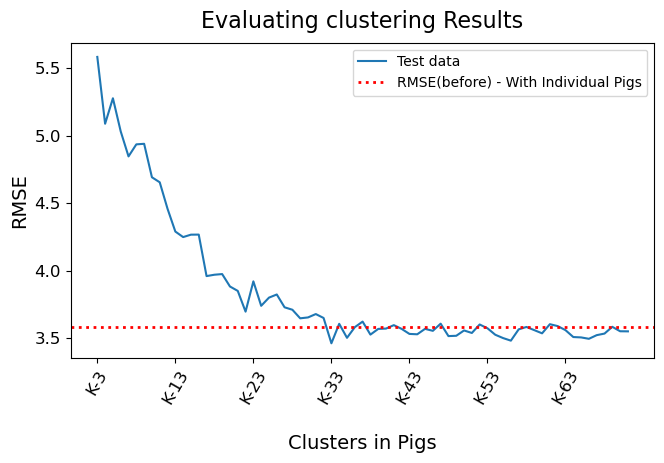

In [18]:
fig, ax = plt.subplots(figsize = (7,5), dpi = 100)
results = res.copy()
results.reset_index(drop=True, inplace=True)

ax.plot(results.name, results.test_mixedlm,  label='Test data')

plt.axline((0, mse_with_Visible_groups), (1, mse_with_Visible_groups), color = 'r', ls=':', \
           linewidth = 2, label = 'RMSE(before) - With Individual Pigs')

labels = results.name[::10]
ticks = range(0, len(results.name), 10)
ax.set_xticks(ticks)
ax.set_xticklabels(labels)

ax.tick_params(axis='x', labelsize=12, rotation=60)
ax.tick_params(axis='y', labelsize=12)
ax.legend()
ax.set_title("Evaluating clustering Results", fontsize = 16, y = 1.02)
ax.set_xlabel('\nClusters in Pigs', fontsize = 14)
ax.set_ylabel("RMSE", fontsize = 14)
plt.tight_layout(pad = 2)
plt.show()

### List of clusters with better performance found than considering 72 pigs individually.

In [21]:
results[results.test_mixedlm < mse_with_Visible_groups]

,name,test_mixedlm
30,K-33,3.461251
32,K-35,3.501871
33,K-36,3.580776
35,K-38,3.525593
36,K-39,3.567829
37,K-40,3.570302
39,K-42,3.568074
40,K-43,3.530770
41,K-44,3.527993
42,K-45,3.568163


In [24]:
reduced_df = get_reduced_data(pca_df, 'K-33')
reduced_df['Pig_ID'] = ordinal_encoder.inverse_transform(np.array(reduced_df['gV']).reshape(-1,1))
grouped = reduced_df.groupby('gE_new').agg({'Pig_ID': 'unique'}).reset_index()
grouped = grouped.rename(columns={'gE_new':'Pig Clusters Found'})
grouped = grouped.set_index('Pig Clusters Found')

In [25]:
grouped

,Pig_ID
Pig Clusters Found,
0,"[4603, 8191]"
1,[4760]
2,"[4817, 6912, 8442]"
3,[6430]
4,"[4757, 8193]"
5,"[4602, 4814, 6055, 8142]"
6,"[5497, 5851, 6287]"
7,"[4605, 4645, 4856, 5501, 8051]"
8,[8144]


#### The K-33 has the best performance across other clusters and considering this, the performance of MixedLM model got better from RMSE of 3.58 to 3.46..